## Задача 1.1

[Задана выборка пар изображений](https://drive.google.com/file/d/156K2MIDP3UqRc5qkH0VpI9IXhWTA-o6G/view?usp=sharing): каждая пара состоит из оригинального (original_id.bmp) изображения и искаженного (modified_id_phrase.bmp).
Также задана пара контрольных изображений original_test, modified_test.

В 99% случаев искажение заключается в добавлении белого шума. В 1% случаев искажение заключается в добавлении к изображению скрытого сообщения. 
Алгоритм заключается в следующем:
1. У исходной фразы берутся порядковые номера всех символов в порядке английского алфавита (abcz -> 0,1,2,25).
2. Полученный вектор домножается на неизвестный коэффициент alpha и складывается с вектором картинки (image = image.flatten() + alpha*v + шум).
3. Если фраза слишком короткая, искажение продолжается периодически.

Требуется раскодировать фразу из контрольной пары.

NB: предполагается, что вы найдете искаженные изображения без шума с применением статистических моделей, а не перебором.


### Ссылки
* https://imageio.readthedocs.io/en/stable/userapi.html
* https://docs.python.org/3/library/functions.html#ord

## Задачи


Enter phystech e-mail

iaremus.dk@phystech.edu

Your tasks are:   

1.1, 2.1, 3.2, 4.1

## Решение

Предположим, что зашифрованные фразы не длиннее 30 символов(если ничего не получится, то возьмем больше). Будем рассматривать разность модифицированной и оригинальной картинок, построим график автокорреляции и по нему сможем определить, при каком значении lag корреляция максимальна. Чтобы не рассматривать все картинки, будем отсекать те, где нет корреляции с помощью теста Q-критерий Льюнга-Бокса. Также необходимо сделать поправку Бонферрони. Далее по тренировочной выборке оцениваем константу - 3.15, и чуть корректируем её из-за ошибок округлений. итого получаем коэф - 3.05, на тестовой кртинке получаем фразу - "Где деньги, Лебовски!?"

In [123]:
import pandas as pd
import os
import numpy as np
import string
from math import sqrt, floor, pi
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from statsmodels.tsa.stattools import acf
from statsmodels.stats.multitest import multipletests

In [181]:
data_dir = "data/images/images_full/images"
files = os.listdir(data_dir)
N = 30
alpha = 0.01
alphabet = string.ascii_lowercase
chr_to_int = {l: ord(l) - ord('a') for l in alphabet}
int_to_chr = {i: l for l, i in chr_to_int.items()}

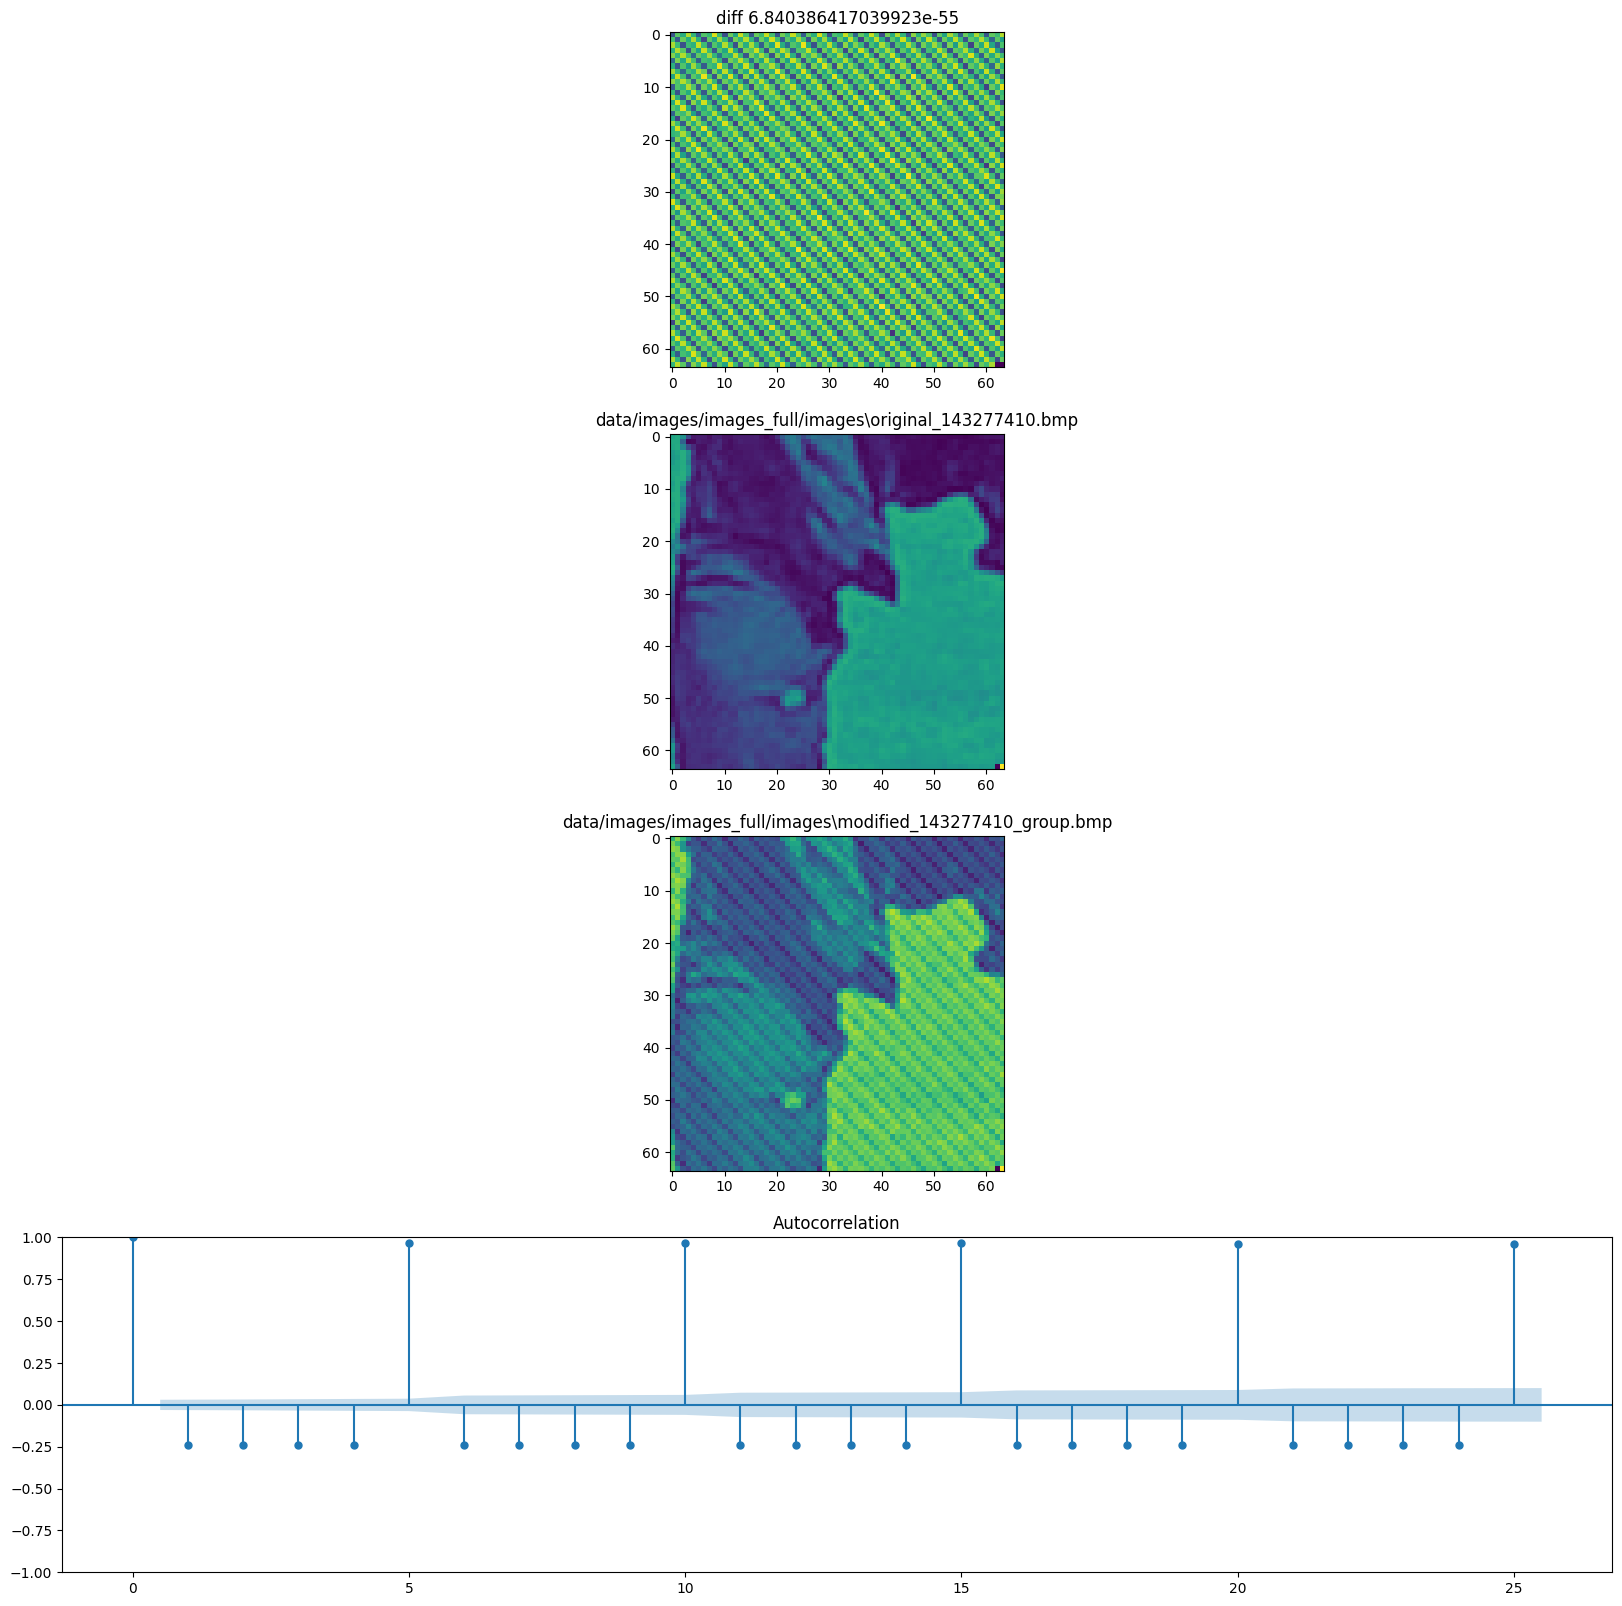

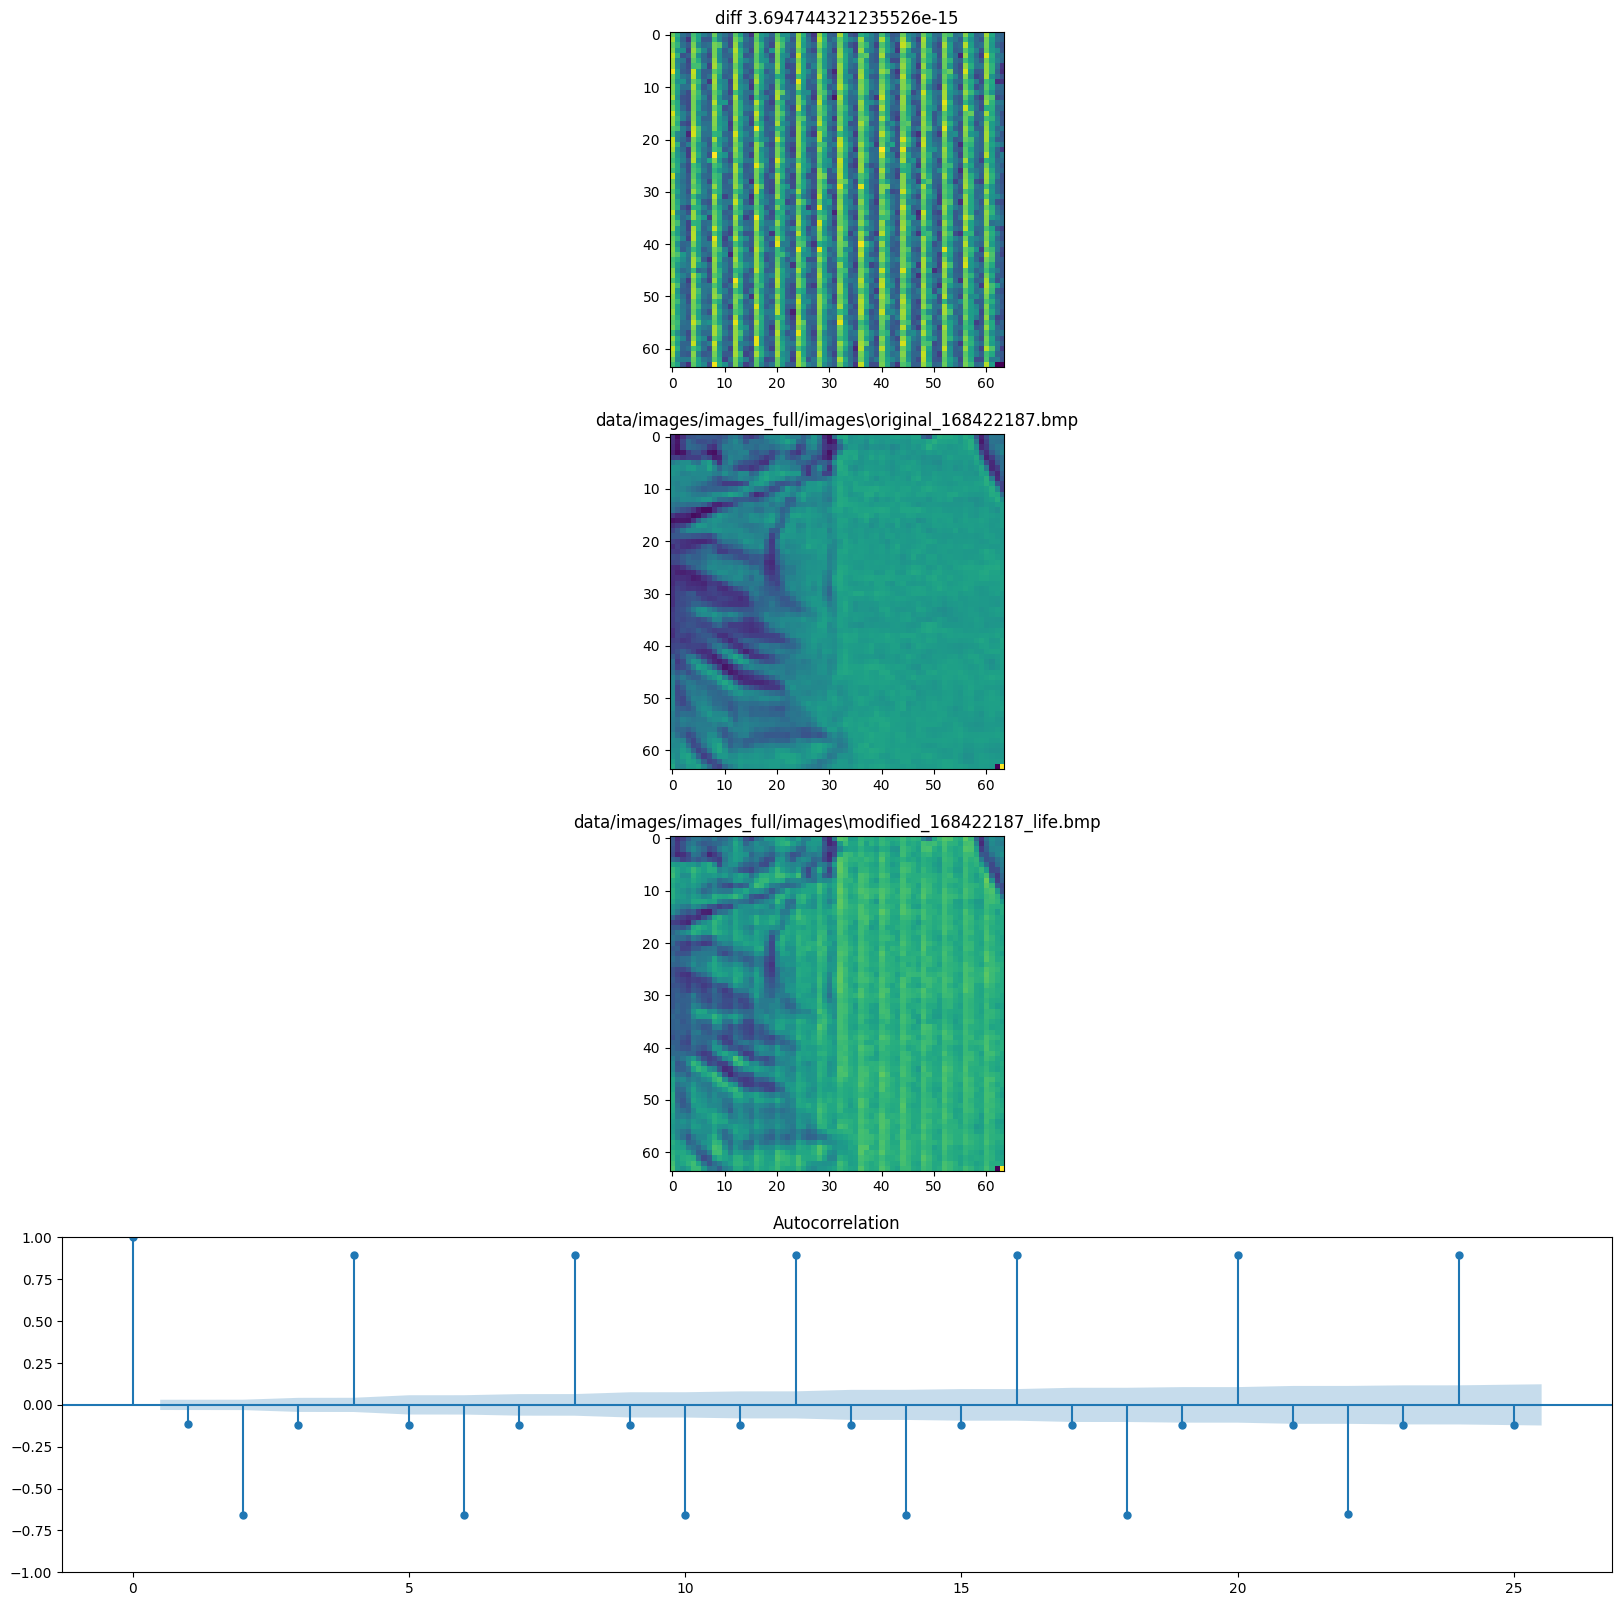

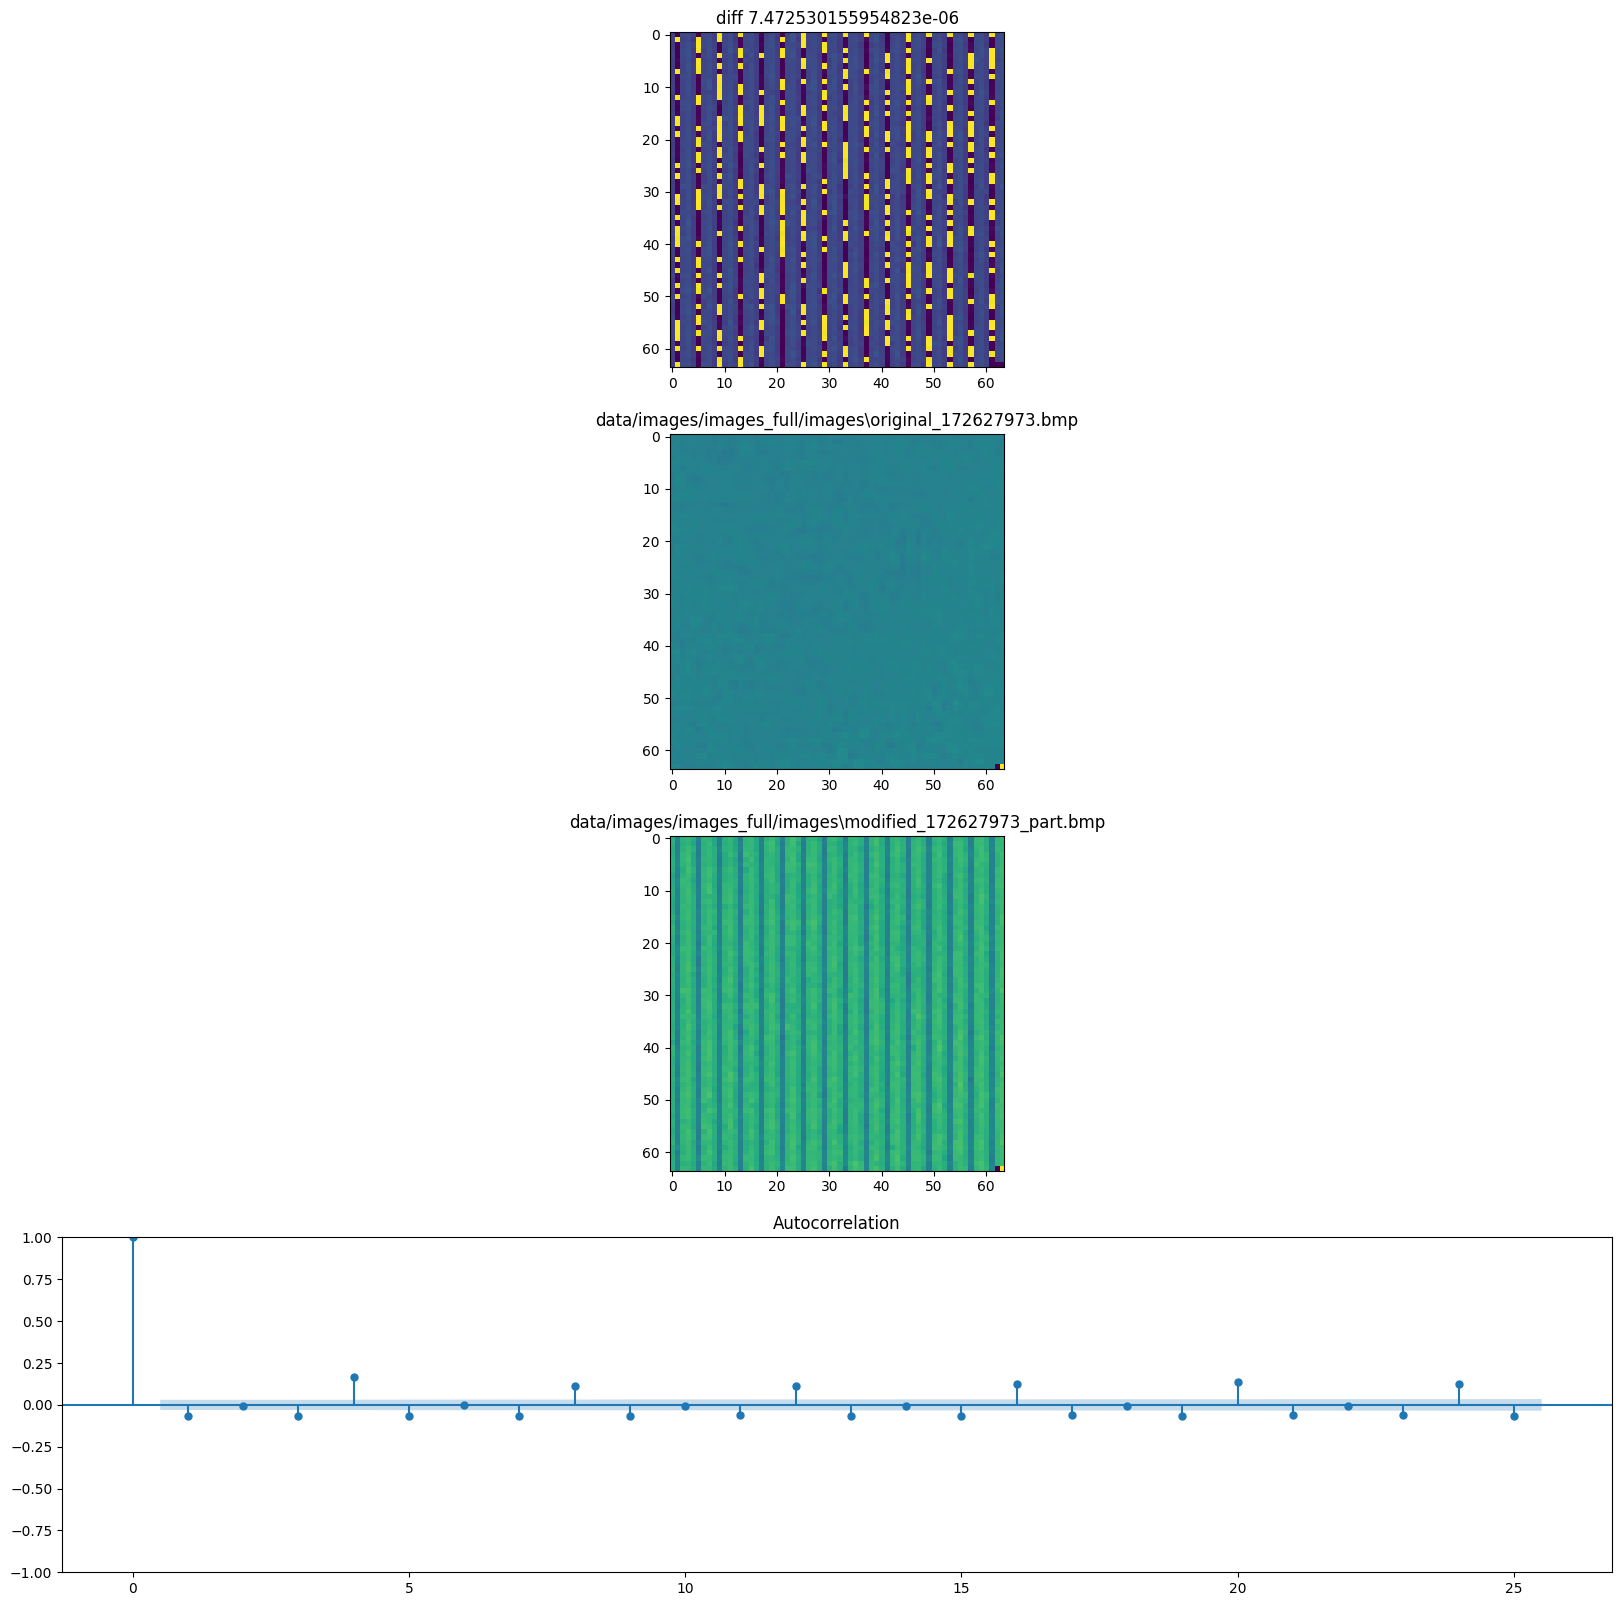

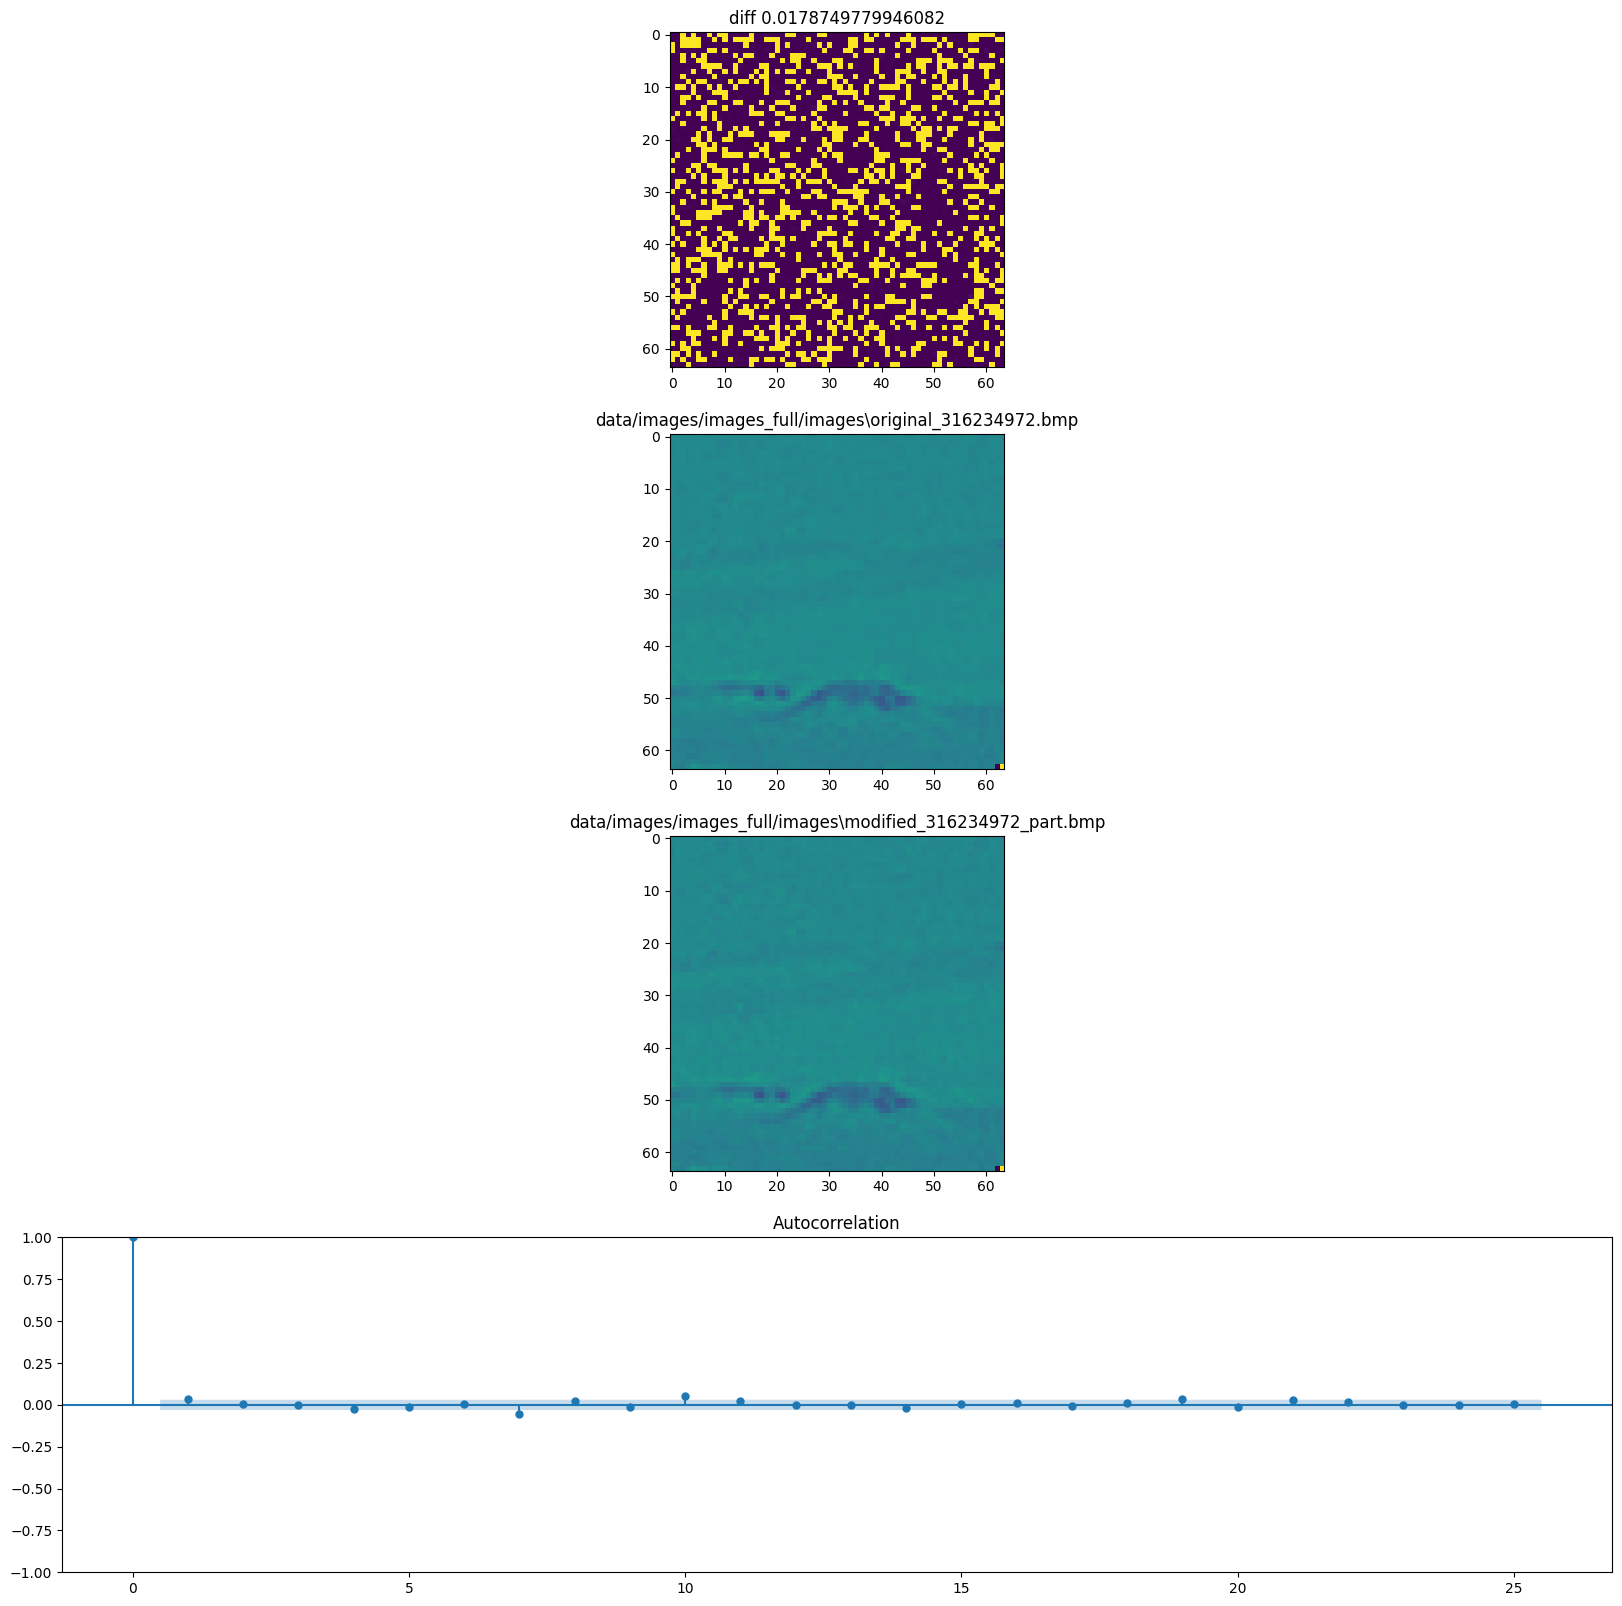

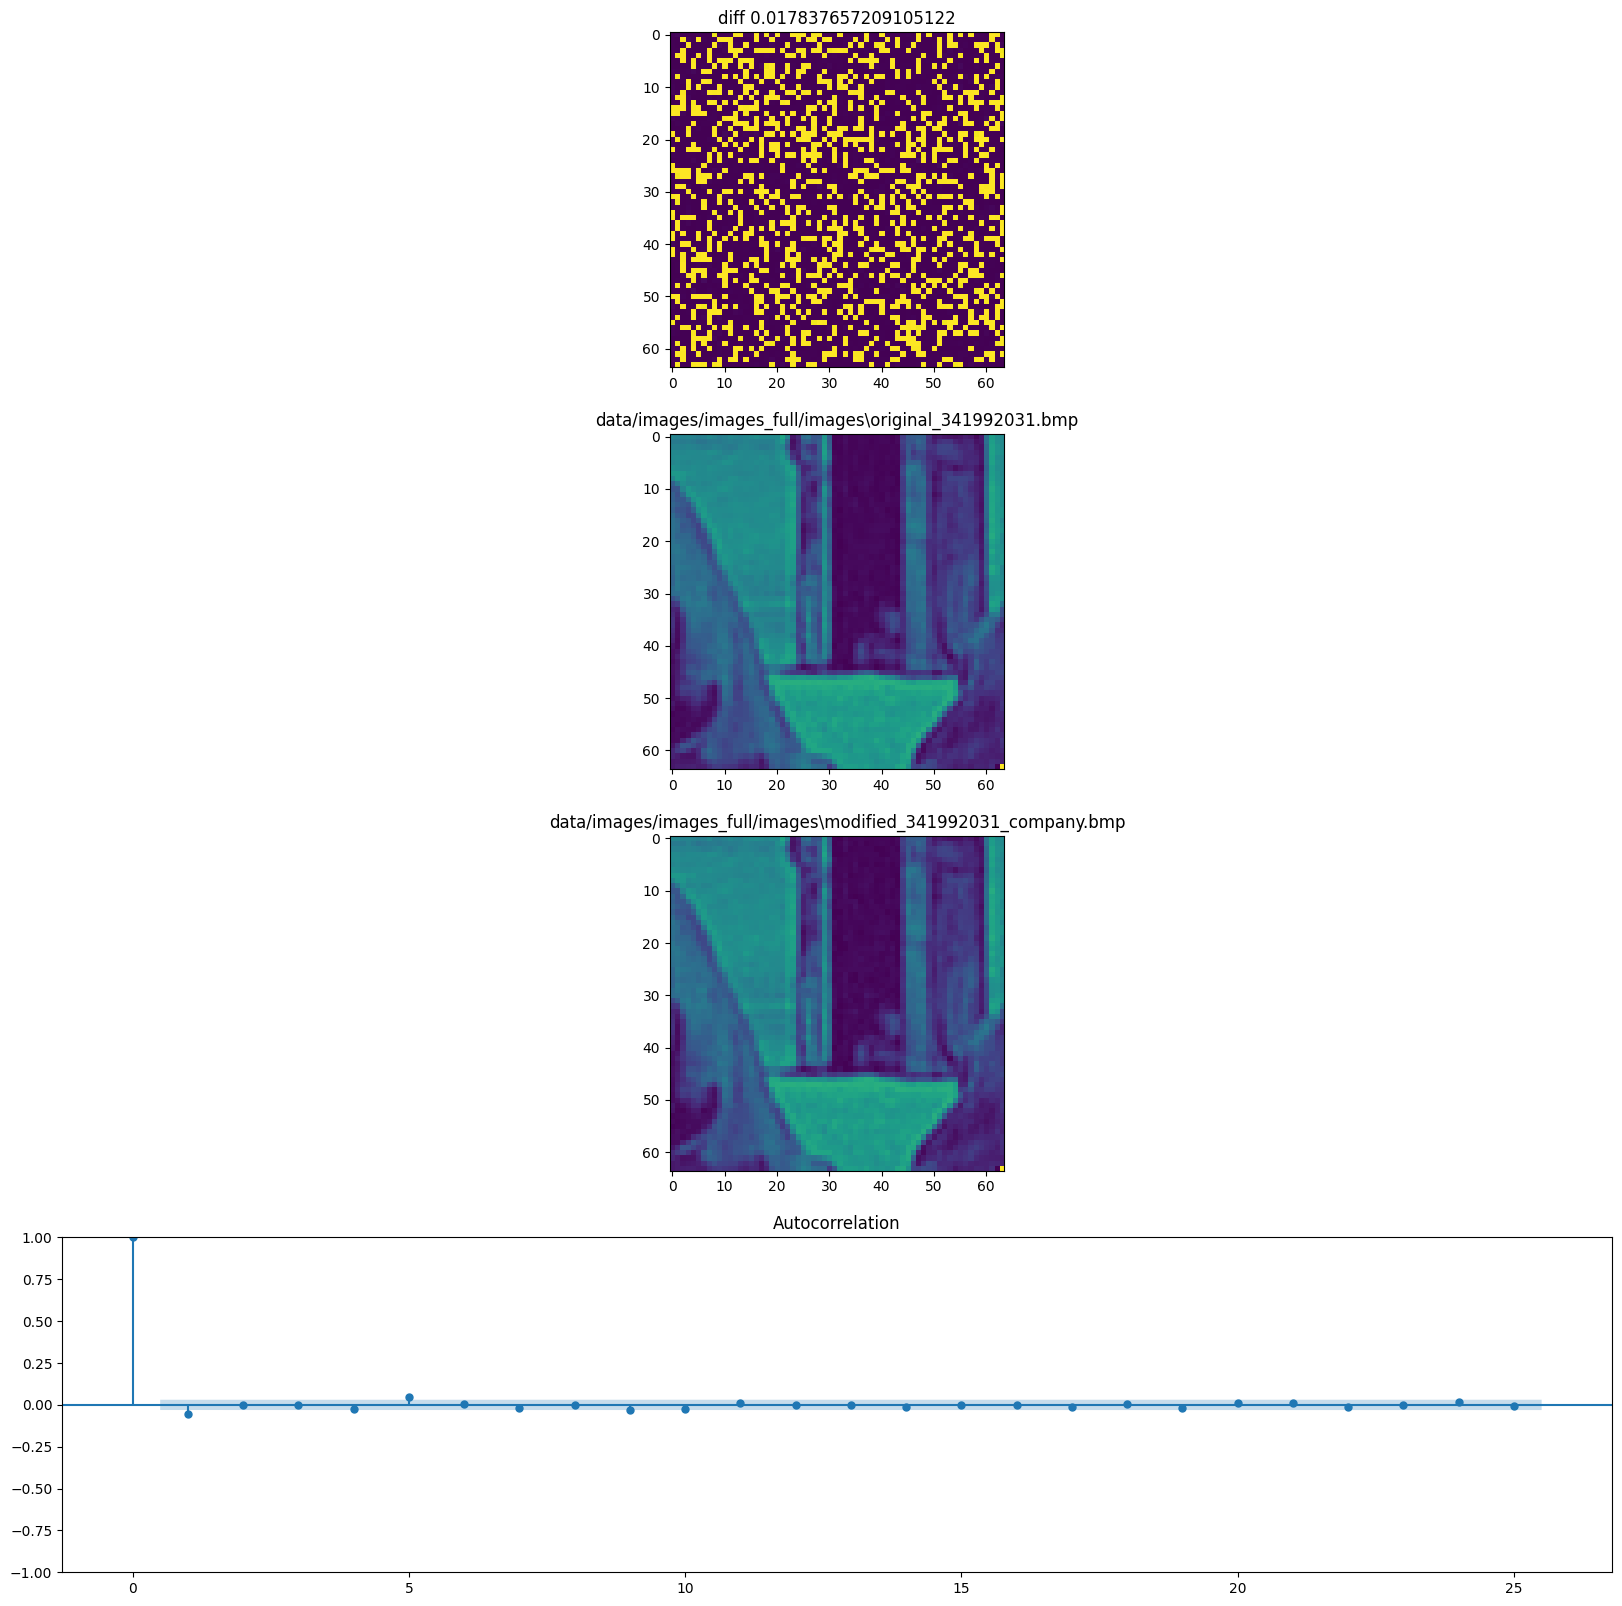

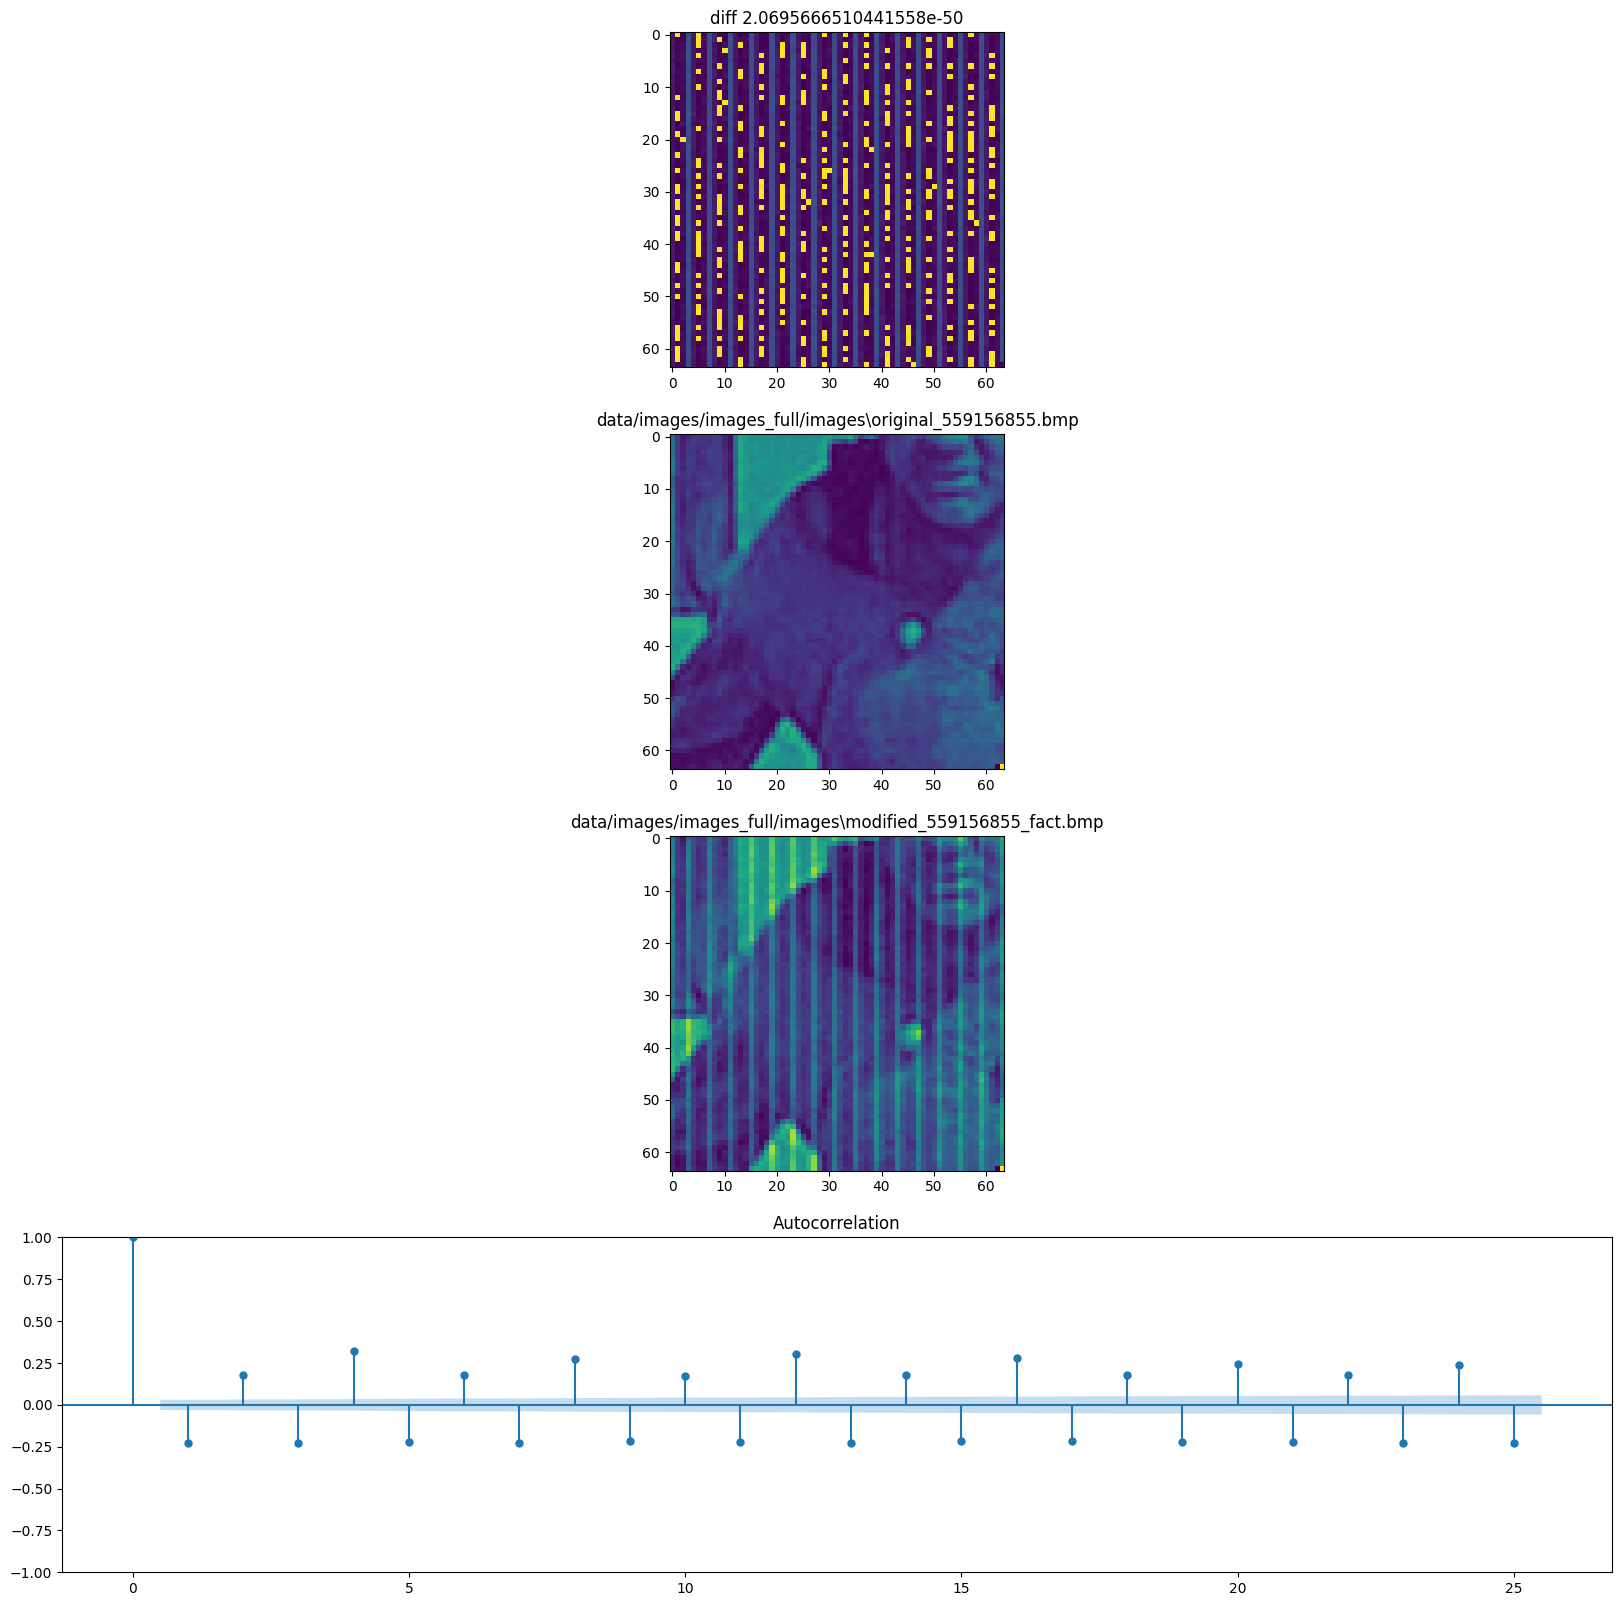

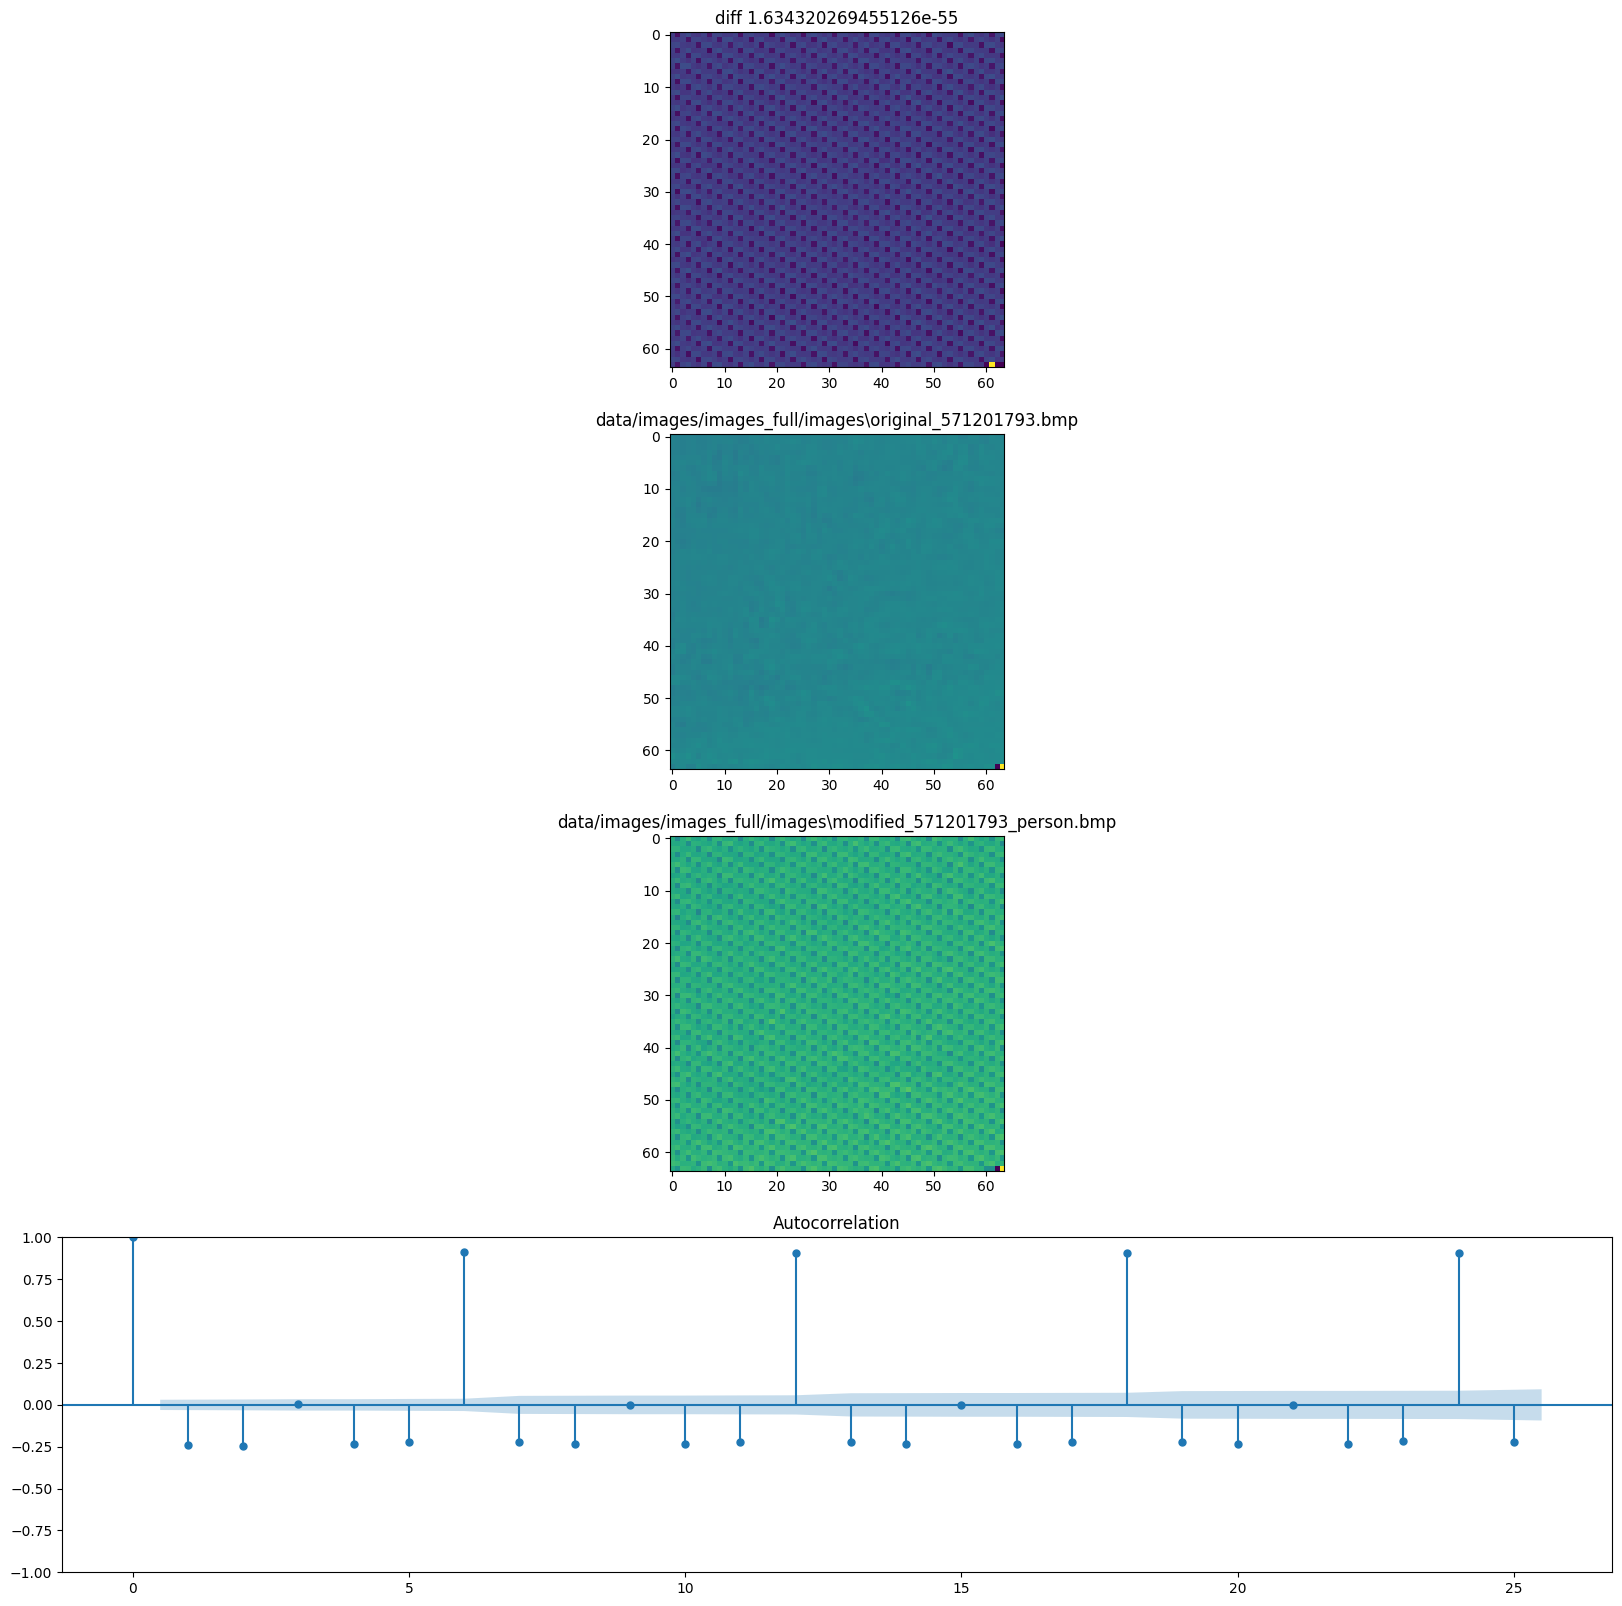

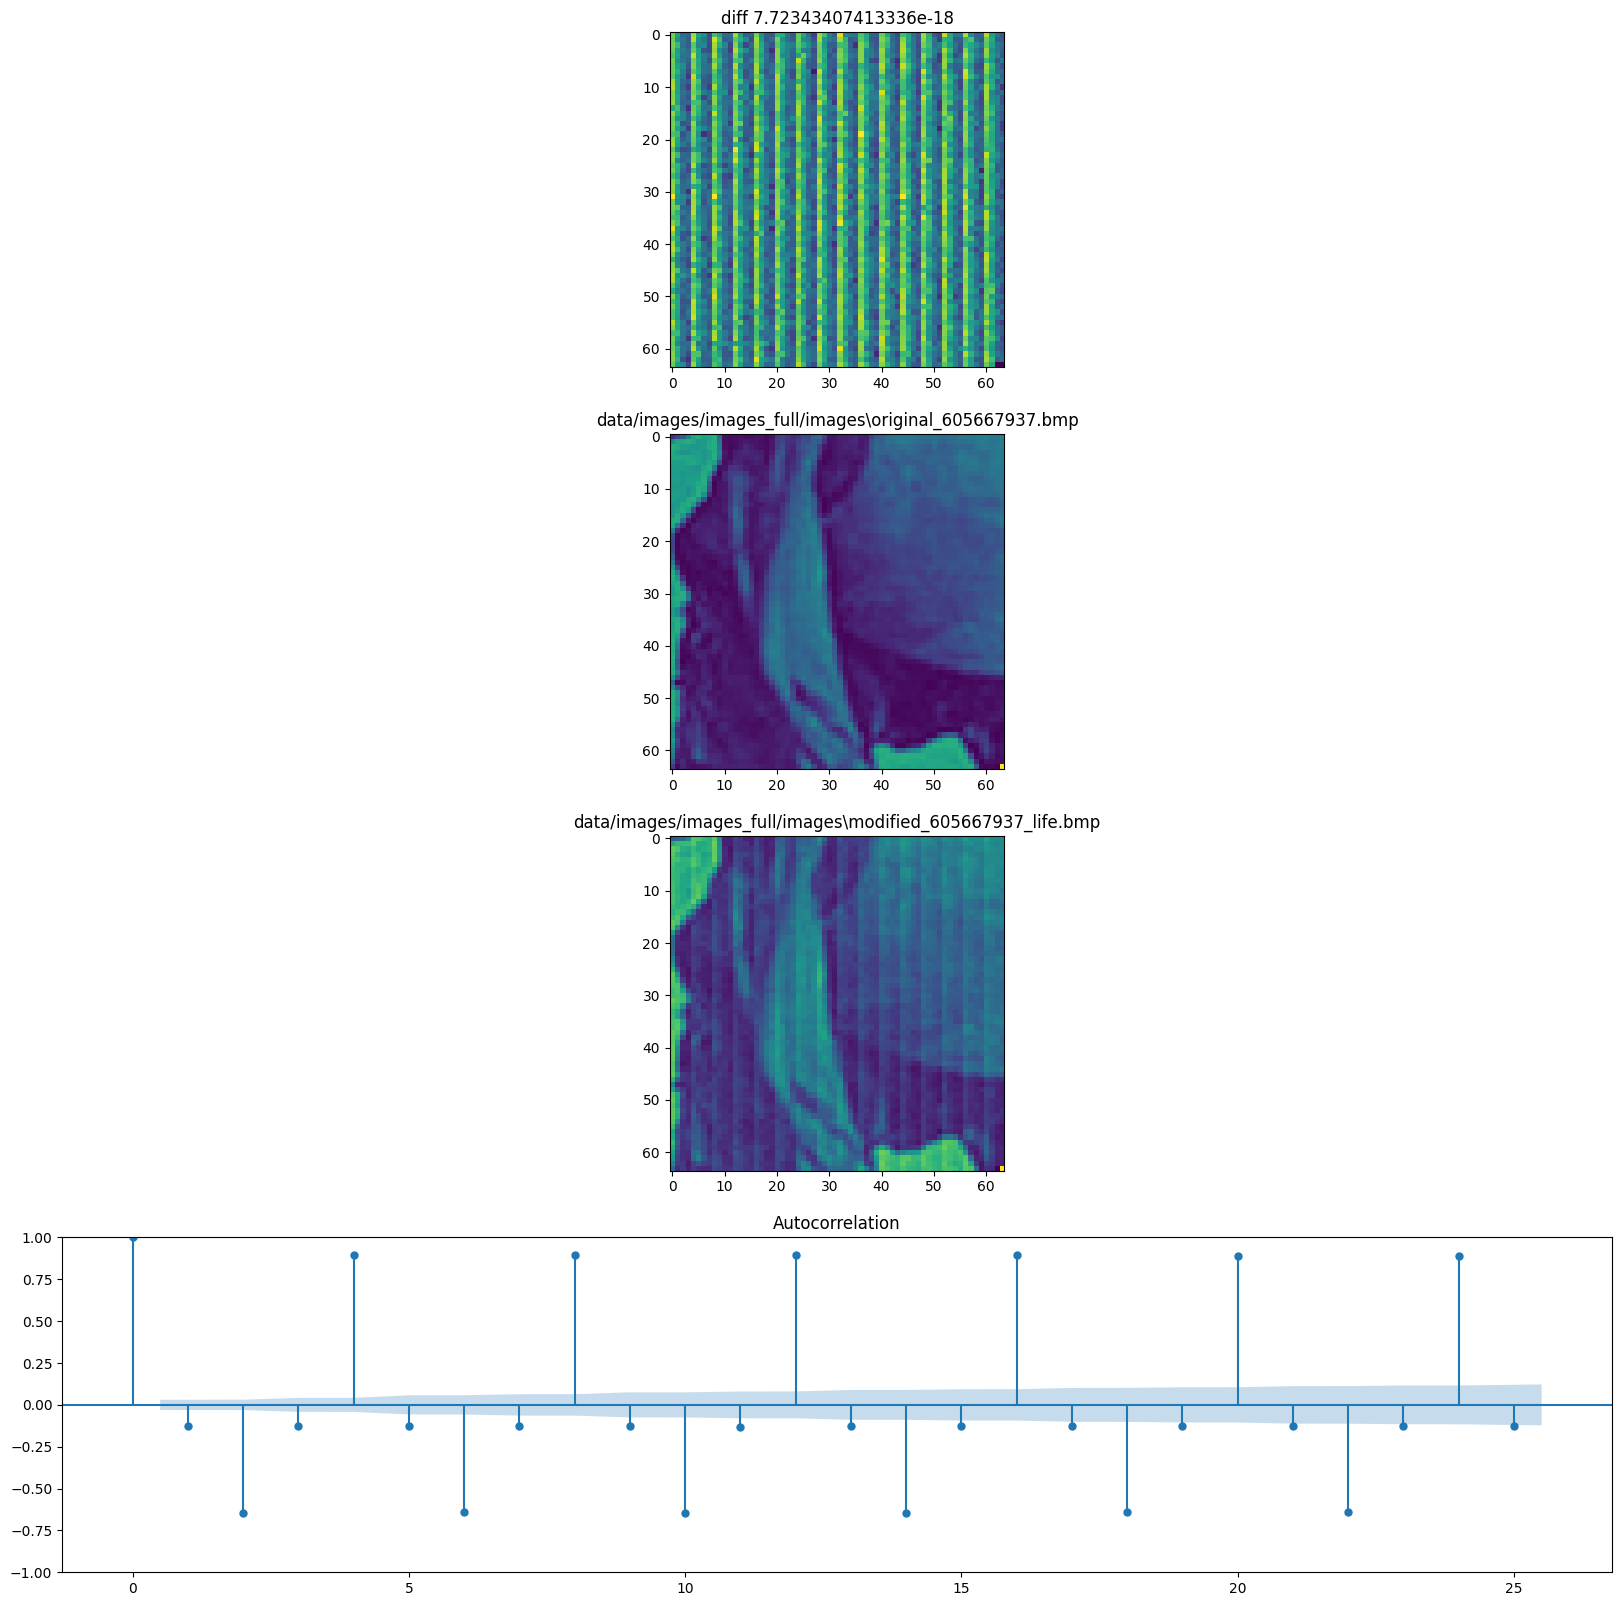

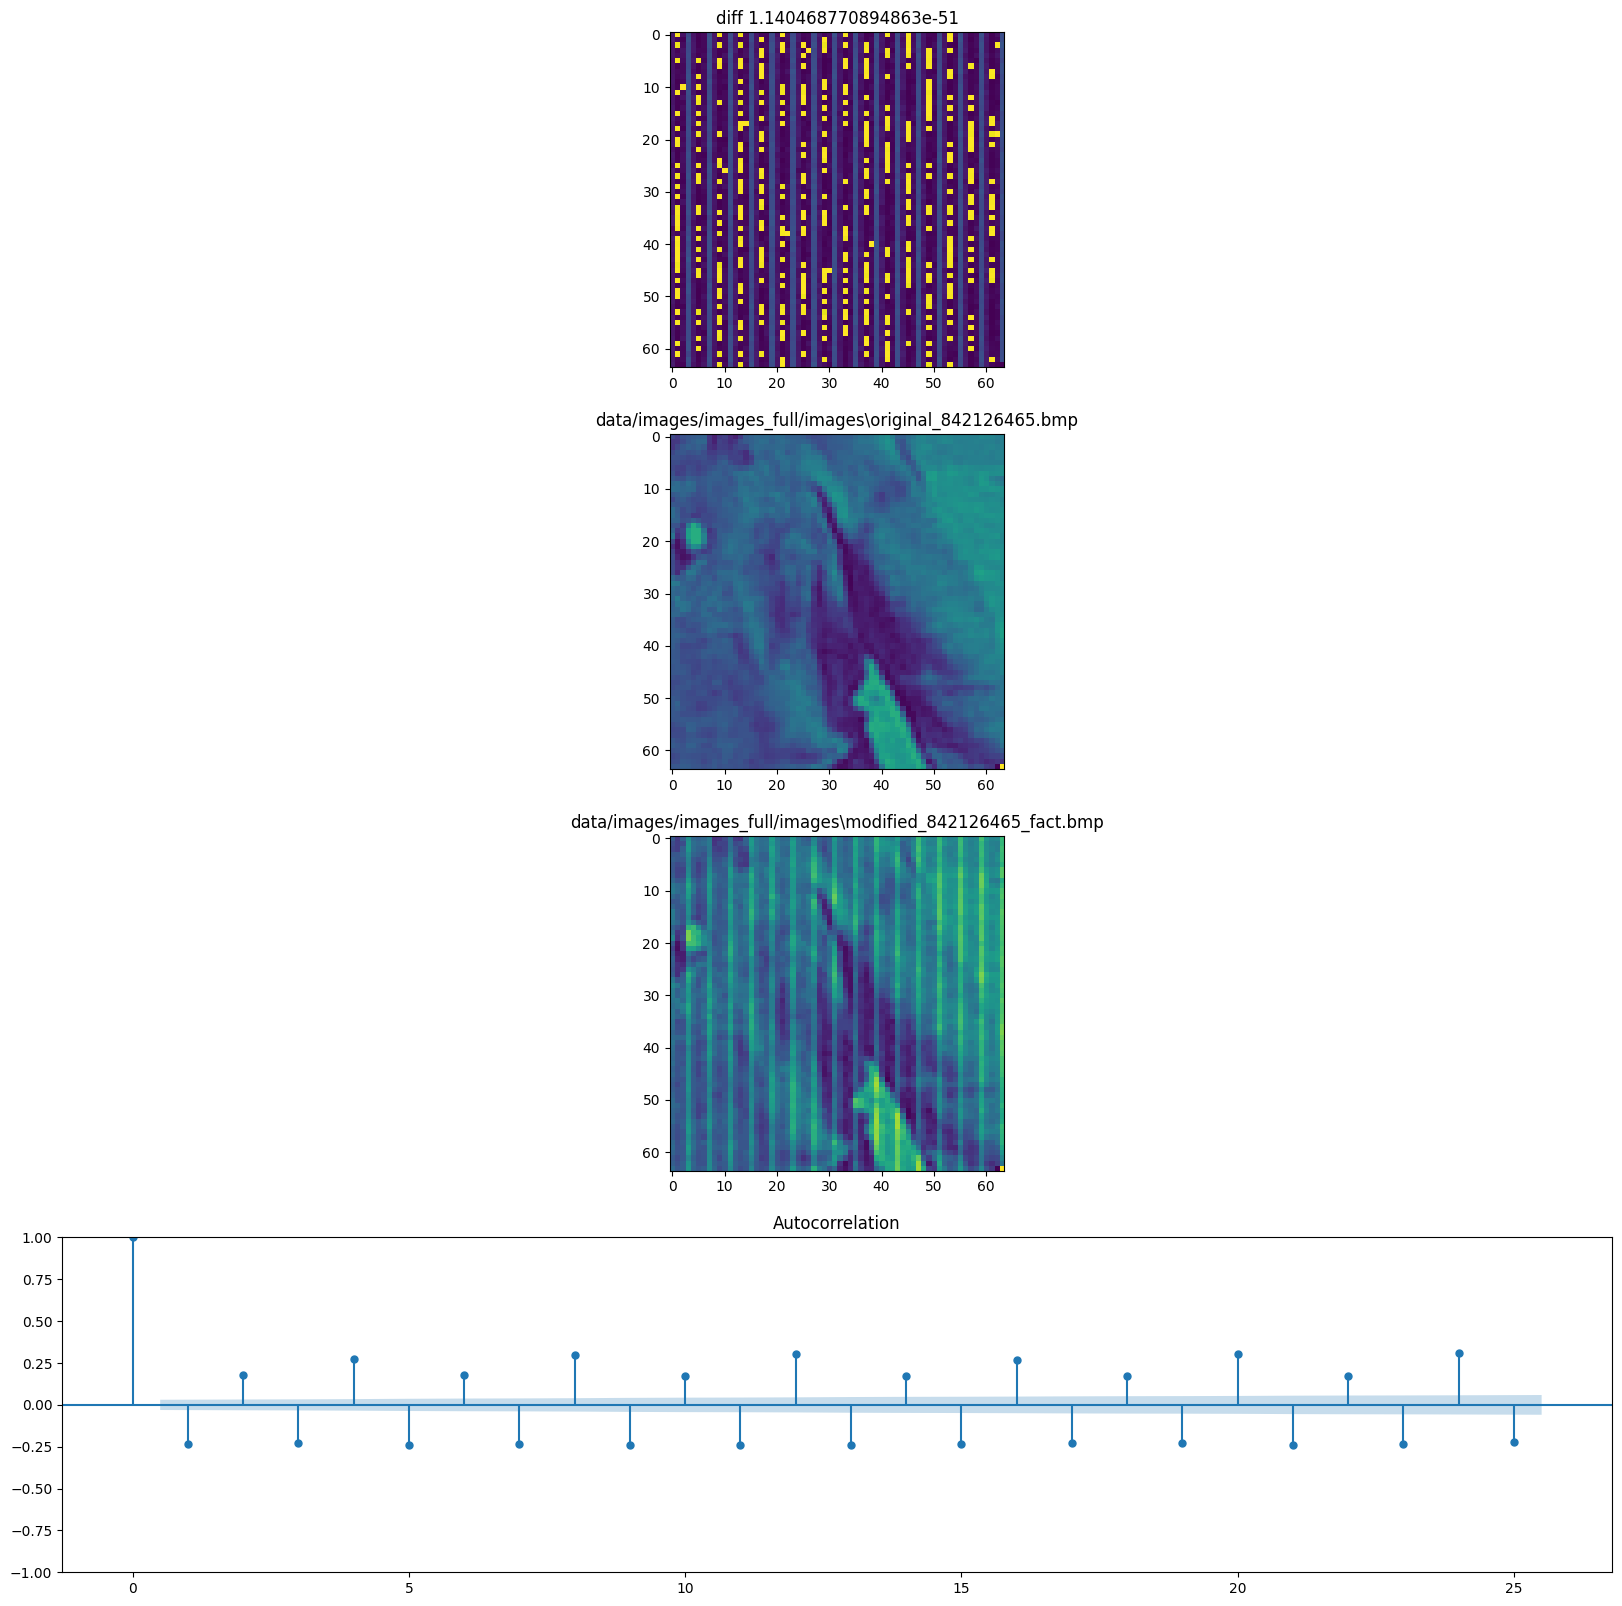

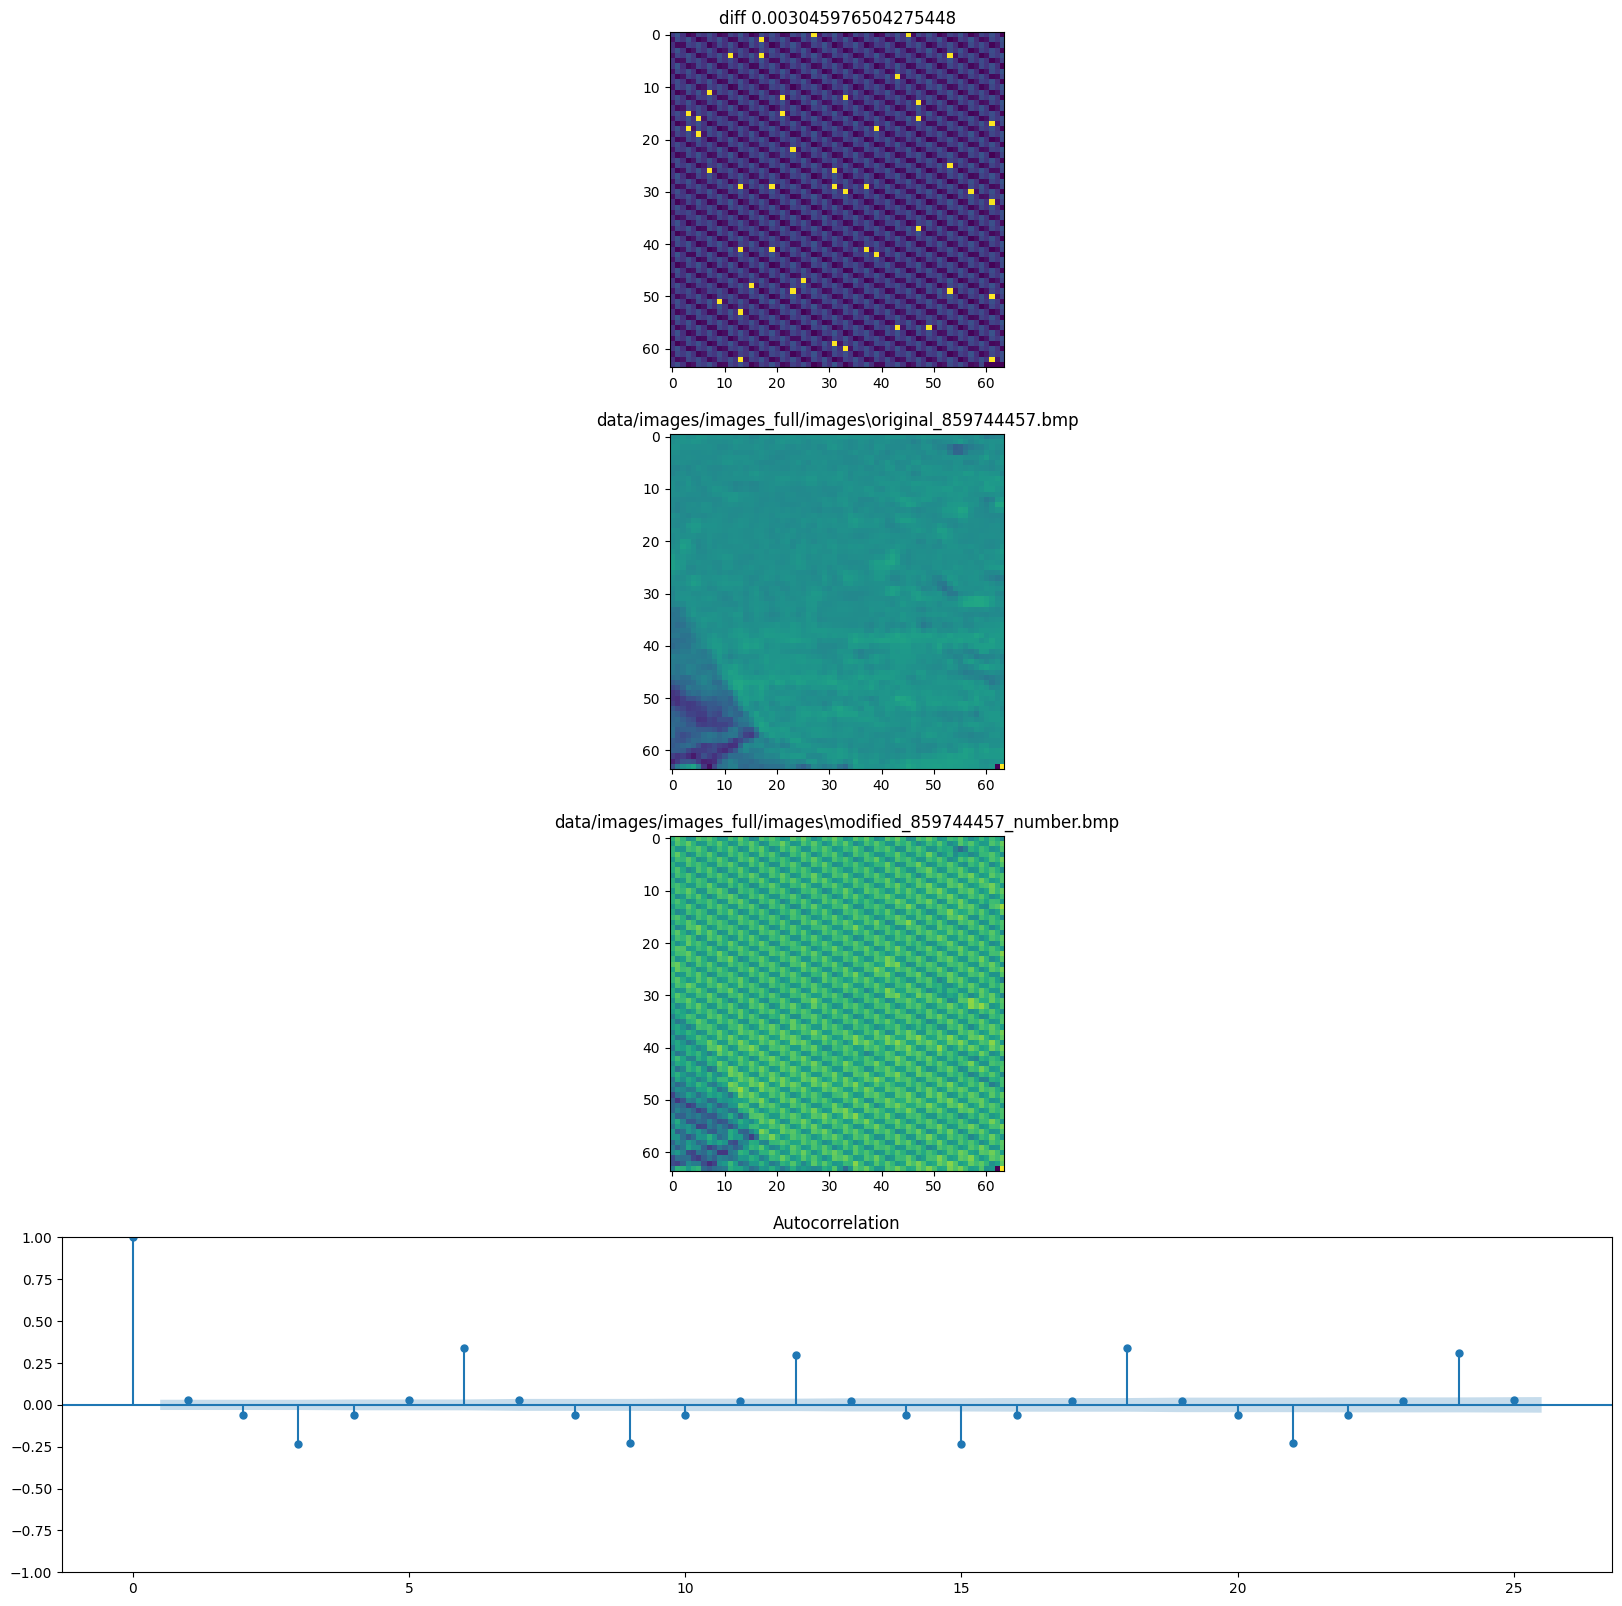

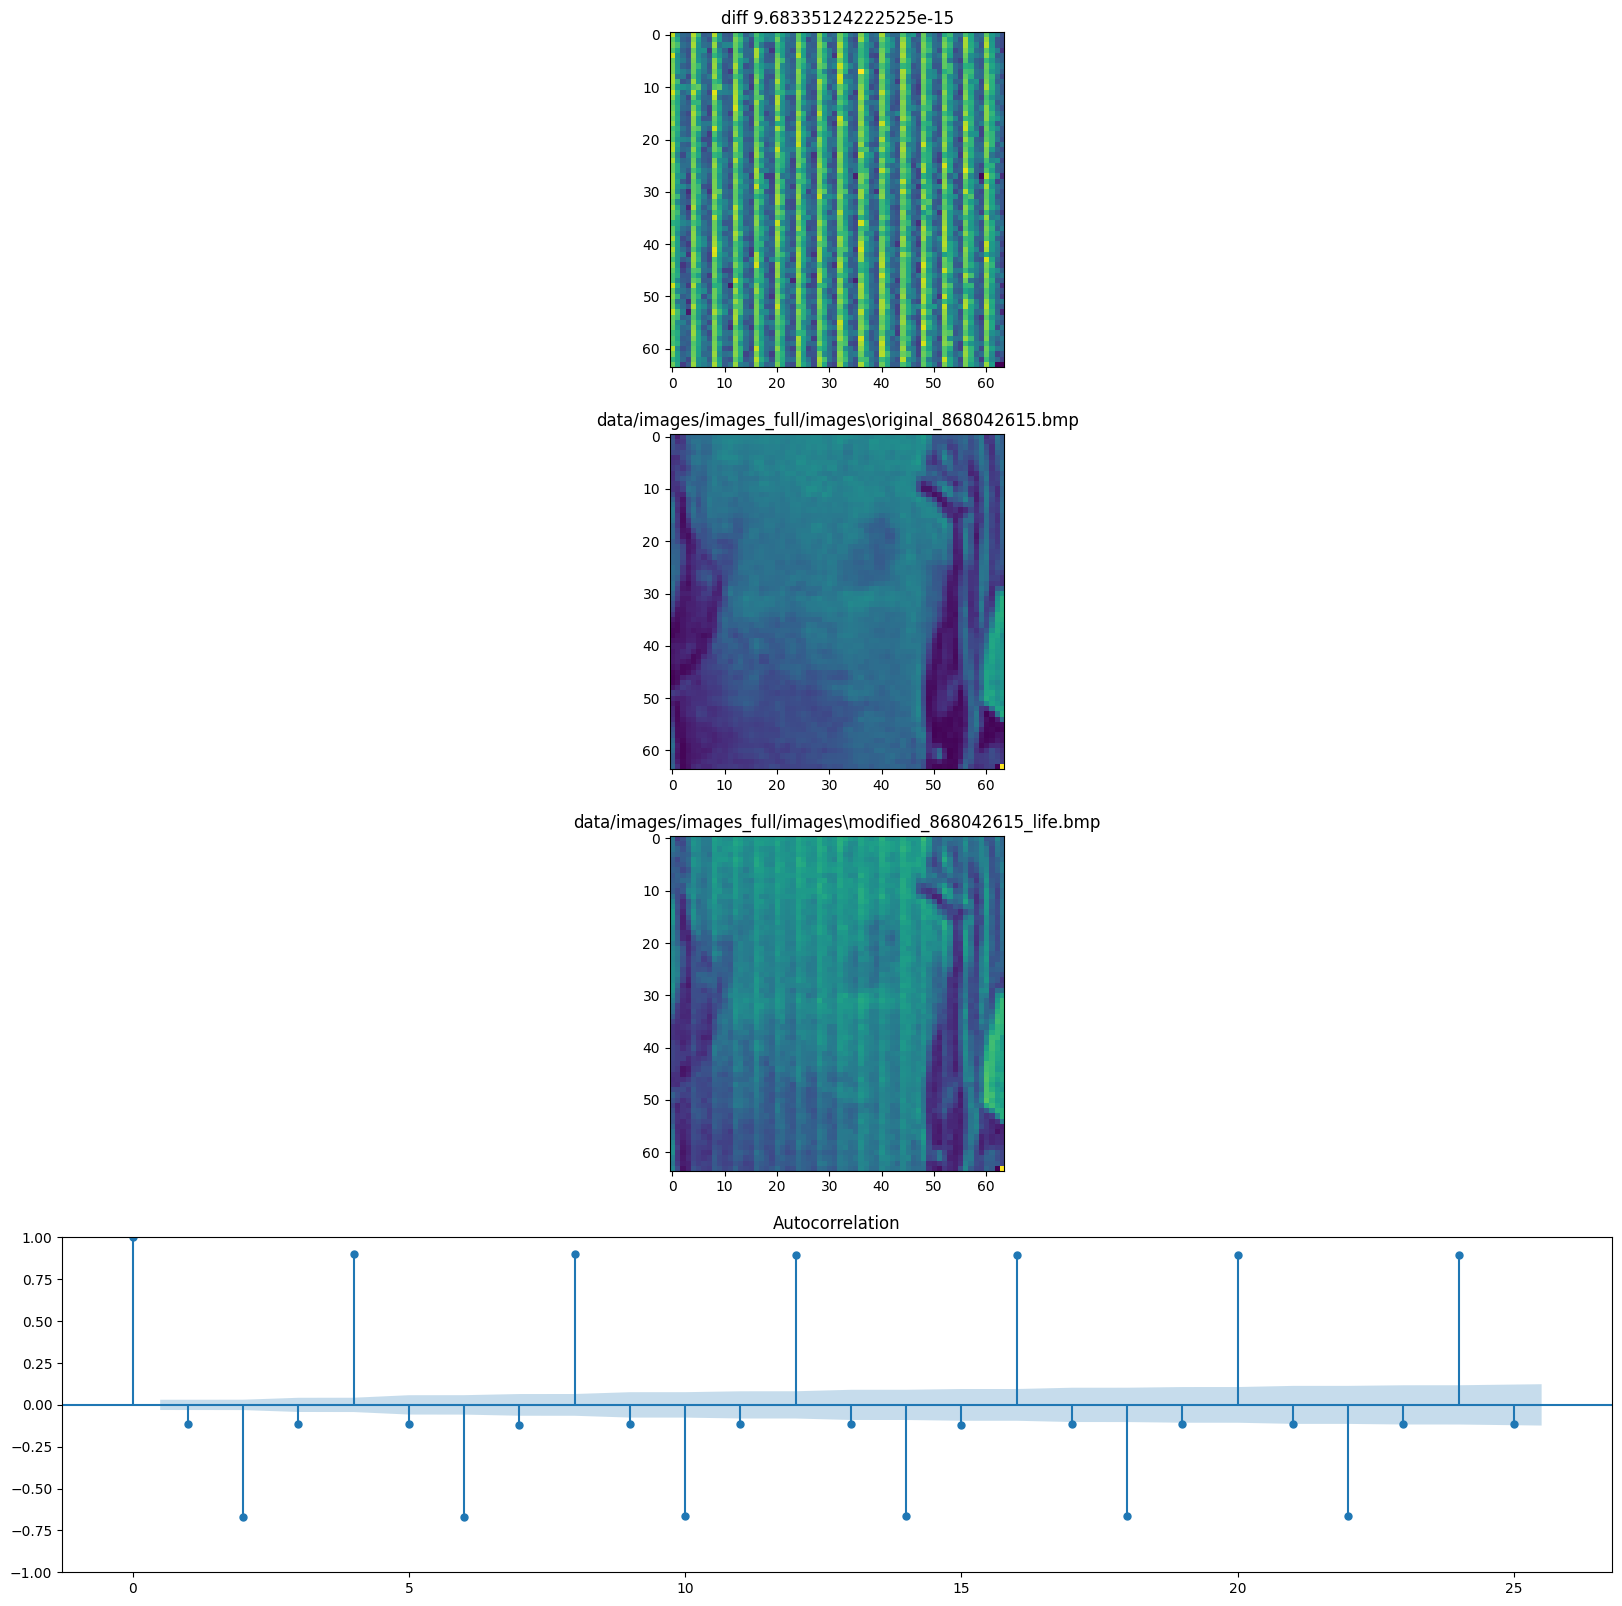

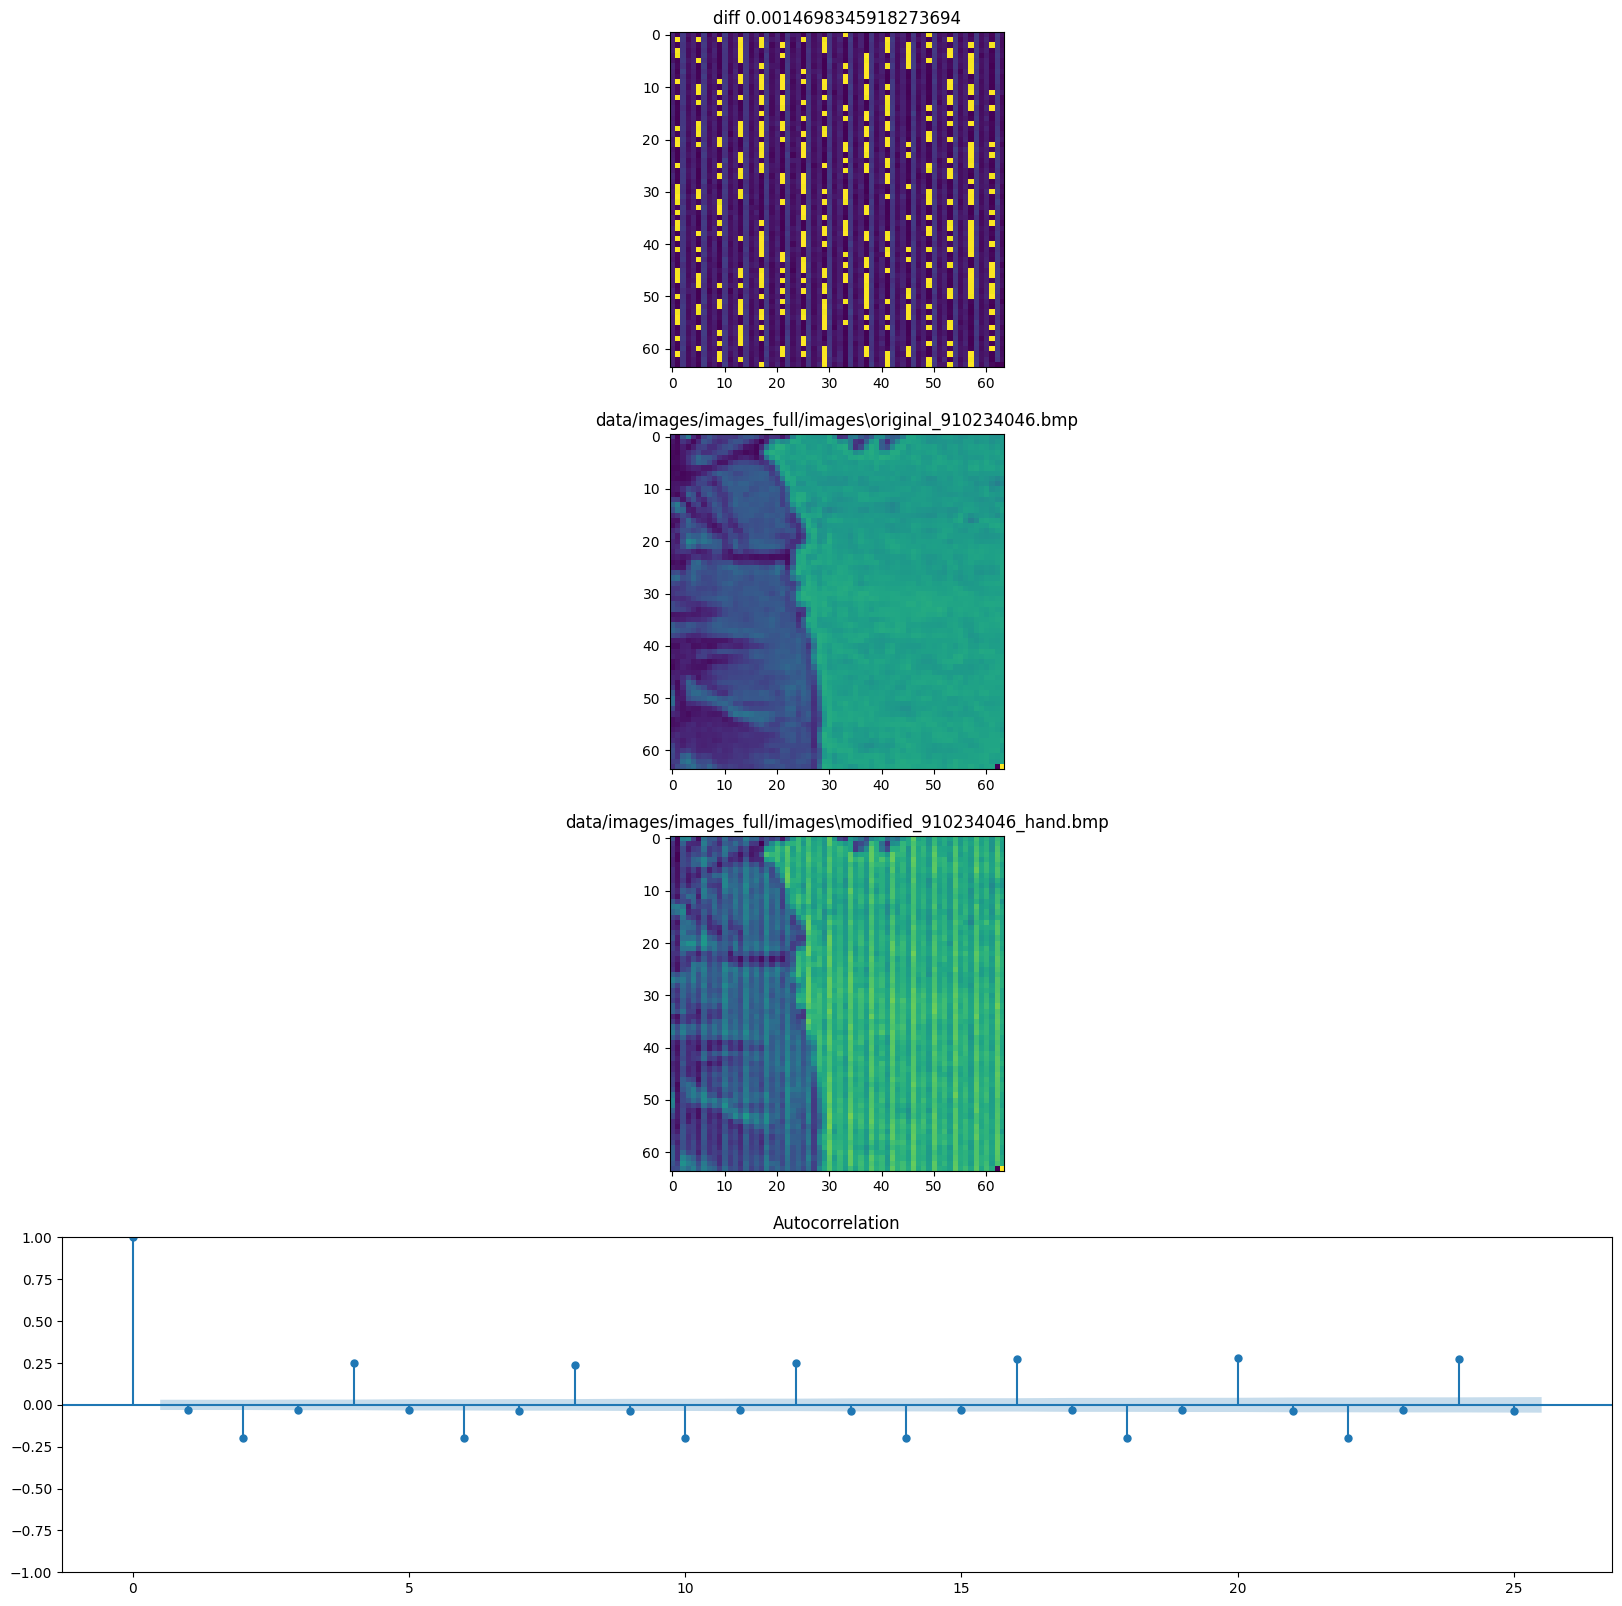

In [182]:
skiped = 0
correlated = []
for file in files:
    if file.startswith("modified"):
        number = int(file[file.find("_") + 1: file.find("_", file.find("_") + 1)])
        res_mod = mpimg.imread(os.path.join(data_dir, file))

        res_orig = mpimg.imread(os.path.join(data_dir, 'original_' + str(number) + '.bmp'))
        # files_groups[number] = {"mod" : np.array(res), "orig" : np.array(res_orig)}

        diff = (res_mod - res_orig).flatten()

        diff_acf, confint, qstat, pvalues = acf(diff, nlags=N, qstat=True, alpha=alpha)

        if np.any(multipletests(pvalues, alpha=alpha, method='bonferroni')[0]):
            fig, ax = plt.subplots(4, figsize=(20, 20))   
            ax[0].imshow(res_mod - res_orig)
            ax[0].set_title('diff ' + str(np.mean(pvalues)))
            ax[1].imshow(res_orig)
            ax[1].set_title(os.path.join(data_dir, 'original_' + str(number) + '.bmp'))
            ax[2].imshow(res_mod)
            ax[2].set_title(os.path.join(data_dir, file))
            correlated.append(file)
            sm.graphics.tsa.plot_acf(diff.squeeze(), lags=25, ax=ax[3])
            plt.show()


Видим, что где-то действительно видна корреляция, а где-то это ошибочно

Найдем коэффициент

In [183]:
for mod_name in correlated:
    word = mod_name.split('_')[2].split('.')[0]
    l = len(word)
    
    num = mod_name.split('_')[1]
    img_mod = mpimg.imread(os.path.join(data_dir, mod_name))
    img_orig = mpimg.imread(os.path.join(data_dir, f'original_{num}.bmp'))
    
    diff = list((img_mod - img_orig).flatten())
    
    if len(diff) % l != 0:
        for i in range(l - (len(diff) % l)):
            diff.append(np.nan)

    diff = np.reshape(diff, (len(diff) // l, l))
    print(mod_name, (np.round(np.nanmean(diff, axis=0)) / np.array([chr_to_int[i] for i in word])).mean())

modified_143277410_group.bmp 3.1421008403361346
modified_168422187_life.bmp 3.1664772727272728
modified_172627973_part.bmp inf
modified_316234972_part.bmp inf
modified_341992031_company.bmp inf
modified_559156855_fact.bmp inf
modified_571201793_person.bmp 3.1514657999952114
modified_605667937_life.bmp 3.1664772727272728
modified_842126465_fact.bmp inf
modified_859744457_number.bmp 6.139693313222725
modified_868042615_life.bmp 3.1664772727272728
modified_910234046_hand.bmp inf


C:\Users\Димас\AppData\Local\Temp\ipykernel_17000\4067773764.py:16: RuntimeWarning: divide by zero encountered in divide
  print(mod_name, (np.round(np.nanmean(diff, axis=0)) / np.array([chr_to_int[i] for i in word])).mean())


Видим, что где-то есть ошибки. Сопоставив это с картинками выше, понимаем, что коэф близок к 3.15, то есть скорее всего равен $\pi$

In [184]:
coef = pi
for mod_name in correlated:
    word = mod_name.split('_')[2].split('.')[0]
    l = len(word)
    print(mod_name)
    
    num = mod_name.split('_')[1]
    img_mod = mpimg.imread(os.path.join(data_dir, mod_name))
    img_orig = mpimg.imread(os.path.join(data_dir, f'original_{num}.bmp'))
    
    diff_scaled = list((img_mod - img_orig).flatten() // coef)
    
    for i in range(len(diff_scaled)):
        if diff_scaled[i] > 25:
            diff_scaled[i] = np.nan
            
    if len(diff_scaled) % l != 0:
        for i in range(l - (len(diff_scaled) % l)):
            diff_scaled.append(np.nan)
 
    diff_scaled = np.reshape(diff_scaled, (len(diff_scaled) // l, l))
    
    print("".join([int_to_chr[elem] for elem in np.round(np.nanmean(diff_scaled, axis=0))]))

modified_143277410_group.bmp
gqouo
modified_168422187_life.bmp
khfe
modified_172627973_part.bmp
oaqs
modified_316234972_part.bmp
aaaa
modified_341992031_company.bmp
aaaaaaa
modified_559156855_fact.bmp
fabt
modified_571201793_person.bmp
odqron
modified_605667937_life.bmp
khfe
modified_842126465_fact.bmp
fabs
modified_859744457_number.bmp
numbeq
modified_868042615_life.bmp
kife
modified_910234046_hand.bmp
hanc


Что-то пи не прокатило, подбором получил значение 3.05

In [186]:
coef = 3.05
for mod_name in correlated:
    word = mod_name.split('_')[2].split('.')[0]
    l = len(word)
    print(mod_name)
    
    num = mod_name.split('_')[1]
    img_mod = mpimg.imread(os.path.join(data_dir, mod_name))
    img_orig = mpimg.imread(os.path.join(data_dir, f'original_{num}.bmp'))
    
    diff_scaled = list((img_mod - img_orig).flatten() // coef)
    
    for i in range(len(diff_scaled)):
        if diff_scaled[i] > 25:
            diff_scaled[i] = np.nan
            
    if len(diff_scaled) % l != 0:
        for i in range(l - (len(diff_scaled) % l)):
            diff_scaled.append(np.nan)
 
    diff_scaled = np.reshape(diff_scaled, (len(diff_scaled) // l, l))
    
    print("".join([int_to_chr[elem] for elem in np.round(np.nanmean(diff_scaled, axis=0))]))

modified_143277410_group.bmp
group
modified_168422187_life.bmp
life
modified_172627973_part.bmp
part
modified_316234972_part.bmp
aaaa
modified_341992031_company.bmp
aaaaaaa
modified_559156855_fact.bmp
fabt
modified_571201793_person.bmp
pdrson
modified_605667937_life.bmp
life
modified_842126465_fact.bmp
fabt
modified_859744457_number.bmp
number
modified_868042615_life.bmp
life
modified_910234046_hand.bmp
hanc


vheresthemoneyleaowski


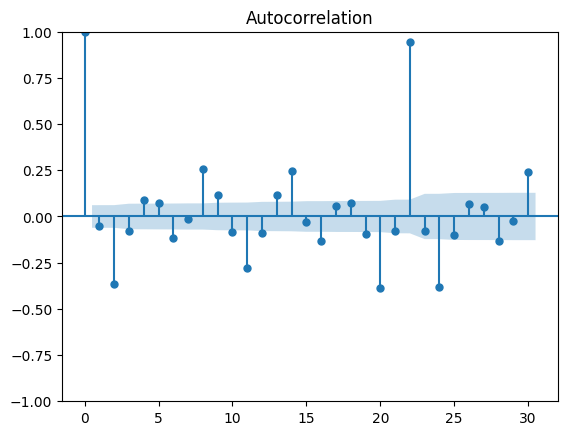

In [188]:
coef = 3.05
img_mod = mpimg.imread('data/images/images_full/modified_test.bmp')
img_orig = mpimg.imread('data/images/images_full/original_test.bmp')

diff_scaled = list((img_mod - img_orig).flatten() // coef)

diff_acf, confint, qstat, pvalues = acf(diff_scaled, nlags=N, qstat=True, alpha=alpha)
sm.graphics.tsa.plot_acf(diff_scaled, lags=30)
l = np.argmax(diff_acf[1:]) + 1

for i in range(len(diff_scaled)):
    if diff_scaled[i] > 25:
        diff_scaled[i] = np.nan
        
if len(diff_scaled) % l != 0:
    for i in range(l - (len(diff_scaled) % l)):
        diff_scaled.append(np.nan)

diff_scaled = np.reshape(diff_scaled, (len(diff_scaled) // l, l))

print("".join([int_to_chr[elem] for elem in np.round(np.nanmean(diff_scaled, axis=0))]))